In [ ]:
!rm -r /content/sample_data

In [ ]:
!rm -r /content/collage
!rm -r /content/processed_frames
!rm -r /content/frames

In [2]:
# Install required packages
!pip install scikit-image opencv-python-headless pywavelets --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 52.3 MB/s eta 0:00:00


🔸 Median Filter (MSE, PSNR, SSIM): (np.float64(212.2115936279297), np.float64(24.863112541061028), np.float64(0.877217377758018))
🔸 Wavelet Filter (MSE, PSNR, SSIM): (np.float64(0.4929911295572917), np.float64(51.20241255827959), np.float64(0.9983214225445222))


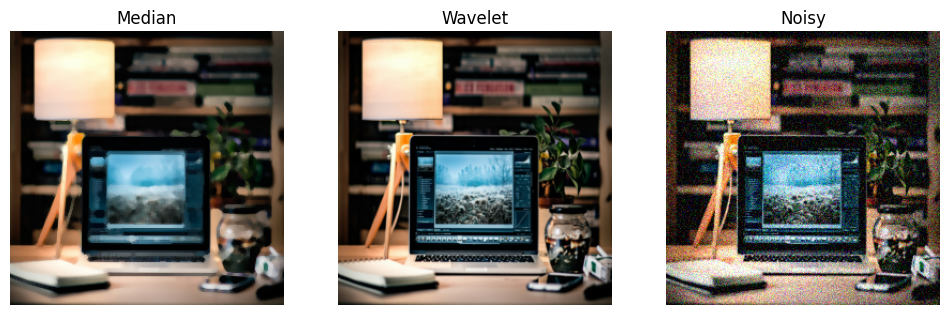

✅ Extracted 243 frames from video.
ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enab

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

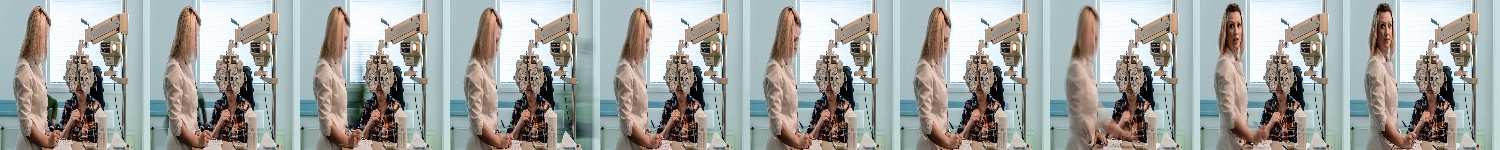

In [4]:
# Imports
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from skimage import img_as_float, restoration, metrics
from skimage.restoration import denoise_wavelet
from skimage.util import random_noise
from skimage.io import imread
from skimage.transform import resize
from PIL import Image
import warnings
warnings.filterwarnings("ignore")

# Paths to pre-uploaded files in Colab
image_path = "/content/sample_image.jpg"  # ⬅️ Replace with your actual image path
video_path = "/content/test.mp4"  # ⬅️ Replace with your actual video path

# Folder setup
os.makedirs("frames", exist_ok=True)
os.makedirs("processed_frames", exist_ok=True)
os.makedirs("collage", exist_ok=True)

# ========================================
# 🔹 PART 1: IMAGE DENOISING
# ========================================

def apply_denoising_filters(img):
    median_filtered = cv2.medianBlur(img, 5)
    wavelet_filtered = denoise_wavelet(img_as_float(img), channel_axis=-1)
    wavelet_filtered = (wavelet_filtered * 255).astype(np.uint8)
    noisy = random_noise(img, var=0.01)
    noisy = (noisy * 255).astype(np.uint8)
    return median_filtered, wavelet_filtered, noisy

def compute_metrics(original, denoised):
    mse = metrics.mean_squared_error(original, denoised)
    psnr = metrics.peak_signal_noise_ratio(original, denoised)
    ssim = metrics.structural_similarity(original, denoised, channel_axis=-1)
    return mse, psnr, ssim

# Load image
img = imread(image_path)
img = resize(img, (256, 256), anti_aliasing=True)
img = (img * 255).astype(np.uint8)

# Apply filters
median, wavelet, noisy = apply_denoising_filters(img)

# Print metrics
print("🔸 Median Filter (MSE, PSNR, SSIM):", compute_metrics(img, median))
print("🔸 Wavelet Filter (MSE, PSNR, SSIM):", compute_metrics(img, wavelet))

# Visualize results
plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.imshow(median); plt.title("Median"); plt.axis('off')
plt.subplot(1,3,2); plt.imshow(wavelet); plt.title("Wavelet"); plt.axis('off')
plt.subplot(1,3,3); plt.imshow(noisy); plt.title("Noisy"); plt.axis('off')
plt.show()

# ========================================
# 🔹 PART 2: EXTRACT FRAMES FROM VIDEO
# ========================================

cap = cv2.VideoCapture(video_path)
i = 0
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    cv2.imwrite(f"frames/frame_{i:04d}.jpg", frame)
    i += 1
cap.release()
print(f"✅ Extracted {i} frames from video.")

# ========================================
# 🔹 PART 3: PROCESS FRAMES
# ========================================

frame_files = sorted(os.listdir("frames"))
for fname in frame_files:
    frame = cv2.imread(os.path.join("frames", fname))
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    adaptive_thresh = cv2.adaptiveThreshold(gray, 255,
                                            cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                            cv2.THRESH_BINARY, 11, 2)
    blurred = cv2.GaussianBlur(gray, (5,5), 0)
    edges = cv2.Canny(gray, 100, 200)
    bitwise_not = cv2.bitwise_not(gray)

    collage = np.hstack([adaptive_thresh, blurred, edges, bitwise_not])
    cv2.imwrite(f"processed_frames/{fname}", collage)

# ========================================
# 🔹 PART 4: RECREATE VIDEO & COLLAGE
# ========================================

import glob
import shutil

# Rebuild the list of processed frame paths
frame_paths = sorted(glob.glob("processed_frames/*.jpg"))

# Use ffmpeg to generate video from processed frames
!rm -rf video_frames && mkdir video_frames

# Copy frames to temp folder with renamed order
for idx, path in enumerate(frame_paths):
    new_name = f"video_frames/frame_{idx:04d}.jpg"
    shutil.copy(path, new_name)

# Use ffmpeg to compile into video
!ffmpeg -y -framerate 20 -i video_frames/frame_%04d.jpg -c:v libx264 -pix_fmt yuv420p processed_video.mp4

# Confirm video size
if os.path.exists("processed_video.mp4") and os.path.getsize("processed_video.mp4") > 0:
    print("✅ Video created using ffmpeg: processed_video.mp4")
    from google.colab import files
    files.download("processed_video.mp4")
else:
    print("❌ ffmpeg video creation failed.")





# Make collage from first 10 frames
collage = []
for fname in frame_files[:10]:
    img = cv2.imread(os.path.join("frames", fname))
    img = cv2.resize(img, (150, 150))
    collage.append(img)

collage_img = np.hstack(collage)
cv2.imwrite("collage/collage.jpg", collage_img)

# Show collage
Image.open("collage/collage.jpg")


In [ ]:
# Install required libraries
!pip install opencv-python torch torchvision scikit-learn pandas numpy matplotlib seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 363.4/363.4 MB 130.9 MB/s eta 0:00:01

In [ ]:

import warnings
warnings.filterwarnings("ignore")


import os
import shutil
import random
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files
import glob
import zipfile

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Define paths and classes
ZIP_PATH = '/content/UCF11_updated_mpg.zip'  # Path to uploaded zip file
SOURCE_DIR = '/content/UCF11_updated_mpg'  # Path to extracted UCF11 dataset
DEST_DIR = '/content/UCF11_subset'  # Path for subset
SELECTED_CLASSES = ['basketball', 'biking', 'diving', 'golf_swinging', 'horse_riding']
VIDEOS_PER_CLASS = 10

# Task 2.1: Verify and extract dataset
def verify_and_extract_dataset():
    """
    Verify if dataset is extracted; if not, extract the zip file
    """
    if os.path.exists(SOURCE_DIR) and os.listdir(SOURCE_DIR):
        print(f"Dataset found at {SOURCE_DIR}")
        print("Available classes:")
        !ls {SOURCE_DIR}
        return True

    print(f"Dataset not found at {SOURCE_DIR}. Checking for {ZIP_PATH}...")
    if not os.path.exists(ZIP_PATH):
        print(f"Error: {ZIP_PATH} not found. Please ensure UCF11_updated_mpg.zip is uploaded.")
        return False

    # Verify file type
    print("Verifying file type...")
    !file {ZIP_PATH}

    # Extract zip
    try:
        with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
            zip_ref.extractall('/content')
        print("Extracted ZIP file successfully")
    except zipfile.BadZipFile as e:
        print(f"Error: Failed to extract {ZIP_PATH}. {str(e)}")
        return False

    if os.path.exists(SOURCE_DIR):
        print("Extraction successful. Available classes:")
        !ls {SOURCE_DIR}
        return True
    else:
        print("Extraction failed or unexpected directory structure")
        return False

# Task 2.2: Create subset
def create_ucf11_subset():
    """
    Create a subset of UCF11 with 5 classes, 10 videos each, handling subfolders
    """
    if not os.path.exists(SOURCE_DIR):
        print(f"Error: Dataset directory {SOURCE_DIR} not found")
        return False

    os.makedirs(DEST_DIR, exist_ok=True)
    for cls in SELECTED_CLASSES:
        class_path = os.path.join(SOURCE_DIR, cls)
        dest_class_path = os.path.join(DEST_DIR, cls)
        os.makedirs(dest_class_path, exist_ok=True)
        if os.path.exists(class_path):
            # Collect all .mpg videos from subfolders
            video_files = glob.glob(os.path.join(class_path, '**/*.mpg'), recursive=True)
            if len(video_files) >= VIDEOS_PER_CLASS:
                selected = random.sample(video_files, VIDEOS_PER_CLASS)
                for video in selected:
                    shutil.copy(video, dest_class_path)
            else:
                print(f"Warning: Class {cls} has only {len(video_files)} videos")
        else:
            print(f"Class directory {class_path} not found")
    print("Subset created at", DEST_DIR)
    print("Subset classes:")
    !ls {DEST_DIR}
    return True

# Task 2.3: Video Dataset Class
class UCF11Dataset(Dataset):
    """
    Custom Dataset for UCF11 subset
    """
    def __init__(self, video_paths, labels, transform=None, frames_per_clip=16):
        self.video_paths = video_paths
        self.labels = labels
        self.transform = transform
        self.frames_per_clip = frames_per_clip

    def __len__(self):
        return len(self.video_paths)

    def __getitem__(self, idx):
        video_path = self.video_paths[idx]
        label = self.labels[idx]

        # Extract frames
        cap = cv2.VideoCapture(video_path)
        frames = []
        frame_count = 0
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break
            if frame_count % 5 == 0:  # Extract every 5th frame
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                frames.append(frame)
            frame_count += 1
        cap.release()

        # Ensure fixed number of frames
        if len(frames) < self.frames_per_clip:
            frames.extend([frames[-1]] * (self.frames_per_clip - len(frames)))
        elif len(frames) > self.frames_per_clip:
            frames = frames[:self.frames_per_clip]

        # Apply transformations
        if self.transform:
            frames = [self.transform(frame) for frame in frames]

        frames = torch.stack(frames)  # Shape: [frames_per_clip, C, H, W]
        return frames, label

# Task 2.4: CNN+LSTM Model
class CNNLSTM(nn.Module):
    """
    CNN+LSTM model for video classification
    """
    def __init__(self, num_classes, hidden_size=128, num_layers=1):
        super(CNNLSTM, self).__init__()
        self.cnn = models.resnet18(pretrained=True)
        self.cnn.fc = nn.Identity()
        self.feature_dim = 512
        self.lstm = nn.LSTM(self.feature_dim, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        batch_size, seq_len, C, H, W = x.size()
        cnn_features = []
        for t in range(seq_len):
            frame = x[:, t, :, :, :]
            features = self.cnn(frame)
            cnn_features.append(features)
        cnn_features = torch.stack(cnn_features, dim=1)
        lstm_out, _ = self.lstm(cnn_features)
        lstm_out = lstm_out[:, -1, :]
        out = self.dropout(lstm_out)
        out = self.fc(out)
        return out

# Task 2.5: Main Execution
def main():
    # Verify and extract dataset
    if not verify_and_extract_dataset():
        return

    # Create subset
    if not create_ucf11_subset():
        return

    # Prepare data
    video_paths = []
    labels = []
    label_map = {cls: idx for idx, cls in enumerate(SELECTED_CLASSES)}

    for cls in SELECTED_CLASSES:
        class_path = os.path.join(DEST_DIR, cls)
        if os.path.exists(class_path):
            videos = [os.path.join(class_path, v) for v in os.listdir(class_path) if v.endswith('.mpg')]
            if len(videos) >= VIDEOS_PER_CLASS:
                video_paths.extend(videos)
                labels.extend([label_map[cls]] * len(videos))
            else:
                print(f"Error: Class {cls} has only {len(videos)} videos in subset")
        else:
            print(f"Error: Class {cls} not found in subset")

    if not video_paths:
        print("No videos found in subset directory. Please check dataset.")
        return

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(video_paths, labels, test_size=0.2, random_state=42, stratify=labels)

    # Define transforms
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((112, 112)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Create datasets
    train_dataset = UCF11Dataset(X_train, y_train, transform=transform)
    test_dataset = UCF11Dataset(X_test, y_test, transform=transform)

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=2)

    # Initialize model, loss, optimizer
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = CNNLSTM(num_classes=len(SELECTED_CLASSES)).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001)

    # Training loop
    num_epochs = 10
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}")

    # Evaluation
    model.eval()
    correct = 0
    total = 0
    y_pred = []
    y_true = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            y_pred.extend(predicted.cpu().numpy())
            y_true.extend(labels.cpu().numpy())

    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=SELECTED_CLASSES, yticklabels=SELECTED_CLASSES)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.savefig('confusion_matrix.png')
    plt.close()

    # Classification Report
    report = classification_report(y_true, y_pred, target_names=SELECTED_CLASSES)
    print("Classification Report:")
    print(report)

    # Save results
    with open('classification_report.txt', 'w') as f:
        f.write(f"Test Accuracy: {accuracy:.2f}%\n\n")
        f.write("Classification Report:\n")
        f.write(report)

    # Zip and download results
    !zip -r results_task2.zip confusion_matrix.png classification_report.txt
    files.download('results_task2.zip')

# Run the pipeline
if __name__ == "__main__":
    main()

Dataset not found at /content/UCF11_updated_mpg. Checking for /content/UCF11_updated_mpg.zip...
Verifying file type...
/content/UCF11_updated_mpg.zip: Zip archive data, at least v2.0 to extract, compression method=store
Error: Failed to extract /content/UCF11_updated_mpg.zip. File is not a zip file
